In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from theta.rtbm import RTBM
from theta.mathtools import normalization_consistency
import numpy as np
import copy
from time import time
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]

In [7]:
ndim = 1
nhid = 2
nevt = 1e3
rtbm = RTBM(ndim, nhid, 
            minimization_bound=50,
            gaussian_init=True,
            positive_T=True, 
            positive_Q=True,
            gaussian_parameters = {"mean" : 0, "std": 0.2},
            sampling_activation = "None"
           )
params_0 = copy.deepcopy(rtbm.get_parameters())

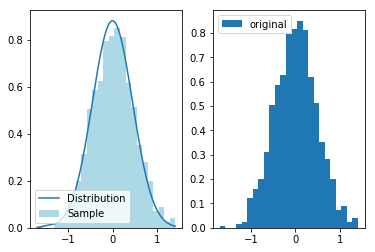

In [8]:
d = 0

def reorder(x, y, z):
    """ Return x, y, z as arrays ordered by x """
    r123 = np.array([ i for i in sorted(zip(x,y,z)) ]).T
    return r123

def get_values():
    xrand, xjac, original_r = rtbm.make_sample_rho(nevt)
    return reorder(xrand[:,d], xjac, original_r[:,d])

x_pre, y_pre, ordered_r = get_values()
        
plt.subplot(1,2,1)
plt.hist(x_pre, bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x_pre, y_pre, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(ordered_r, bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 369.1079835922279


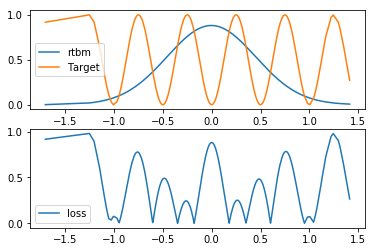

In [9]:
def my_fun(xarr):
    res = pow(np.sin(xarr*np.pi*2.0), 2)
    return res

def kl(x, y):
    return -(y*np.log(x))

def mse(x, y):
    return (x-y)**2

def labs(x,y):
    return np.abs(x-y)

loss = labs

my_y = my_fun(x_pre)
ll = loss(y_pre, my_y)

plt.subplot(2,1,1)
plt.plot(x_pre, y_pre, label="rtbm")
plt.plot(x_pre, my_y, label = "Target")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x_pre, ll, label="loss")
_ = plt.legend()
print(f"Total loss: {np.sum(ll)}")

In [10]:
def generate_loss(xinput):

    def target_loss(params):
        if not rtbm.set_parameters(params):
            return np.NaN
        new_x, prob = rtbm.get_transformation(xinput.reshape(-1,1))
        y = my_fun(new_x[:,d])
        return np.sum(loss(prob, y))
    
    return target_loss

# GA parameters
iterations = 3000
original_sigma = 0.2
sigma = original_sigma
epsilon = 1e-3
mutation_rates = np.array([0.2, 0.4, 0.6, 0.8])
population_per_rate = 128
rates = np.concatenate([np.ones(population_per_rate)*mr for mr in mutation_rates])
ss = len(params_0)

min_bound, max_bound = rtbm.get_bounds()
repeats = 3

with Parallel(n_jobs=32) as parallel:
    
    best_parameters = params_0
    prev = time()
    
    x_input = x_pre
    target_loss = generate_loss(x_pre)
    loss_val = target_loss(best_parameters)
    print(f"Starting loss: {loss_val}")
    
    for it in range(iterations):
        
        p0 = copy.deepcopy(best_parameters)
        
        def compute_mutant(mrate):
            nm = int(ss*mrate)
            mut_idx = np.random.choice(ss, nm, replace=False)
            r1, r2 = np.random.rand(2, nm)*sigma

            mutant = copy.deepcopy(p0)
            var_plus = max_bound - p0
            var_minus = min_bound - p0
            mutant[mut_idx] += var_plus[mut_idx]*r1 + var_minus[mut_idx]*r2
            
            return target_loss(mutant), mutant
    
        parallel_runs = [delayed(compute_mutant)(rate) for rate in rates]
        result = parallel(parallel_runs)
        losses, mutants = zip(*result)
        
        best_loss = np.nanmin(losses)
        if best_loss < loss_val:
            loss_val = best_loss
            best_parameters = mutants[losses.index(best_loss)]
        else:
            sigma /= 2
            
        if it % 50 == 0:
            current = time()
            print(f"Iteration: {it}, best loss: {loss_val:.2f}, time: {current-prev:.2f}s")
            prev = current
            
        if sigma < epsilon:
            sigma = original_sigma
            repeats -= 1
            
            #x_input, _ = rtbm.make_sample(nevt)
            #target_loss = generate_loss(x_input)
            #loss_val = target_loss(best_parameters)
            #print(f"Resetting sigma, new loss: {loss_val}")
        
        if not repeats:
            print(f"No more repeats allowed, iteration: {it}, loss: {loss_val}")
            break
    rtbm.set_parameters(best_parameters)

Starting loss: 619.1610927370734
Iteration: 0, best loss: 369.47, time: 3.00s
Iteration: 50, best loss: 303.33, time: 95.52s
Iteration: 100, best loss: 272.06, time: 108.77s
Iteration: 150, best loss: 246.33, time: 109.92s
Iteration: 200, best loss: 225.89, time: 113.60s
Iteration: 250, best loss: 210.87, time: 106.53s
Iteration: 300, best loss: 197.92, time: 104.71s
Iteration: 350, best loss: 189.16, time: 103.13s
Iteration: 400, best loss: 180.31, time: 102.82s
Iteration: 450, best loss: 174.15, time: 105.38s
Iteration: 500, best loss: 168.57, time: 107.82s
Iteration: 550, best loss: 164.28, time: 105.09s
Iteration: 600, best loss: 158.56, time: 109.03s
Iteration: 650, best loss: 156.18, time: 105.97s
Iteration: 700, best loss: 154.93, time: 105.65s
Iteration: 750, best loss: 152.71, time: 109.58s
Iteration: 800, best loss: 149.90, time: 109.65s
Iteration: 850, best loss: 146.85, time: 106.61s
Iteration: 900, best loss: 144.54, time: 102.91s
No more repeats allowed, iteration: 905, l

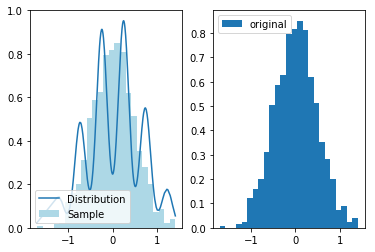

In [17]:
post_x, post_px = rtbm.get_transformation(x_input.reshape(-1,1))
x_post, y_post, ordered_post = reorder(post_x[:,d], post_px, x_input)

plt.subplot(1,2,1)
plt.hist(x_post, bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x_post, y_post, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(ordered_post, bins=25, density=True, label="original")
_ = plt.legend()

Total loss: 369.1079835922279


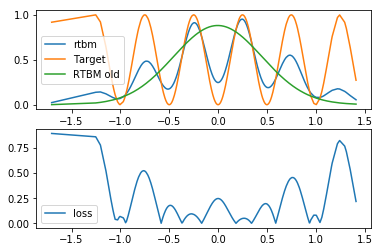

In [23]:
my_y_post = my_fun(x_post)
ll_post = loss(my_y_post, y_post)


plt.subplot(2,1,1)
plt.plot(x_post, y_post, label="rtbm")
plt.plot(x_post, my_y_post, label = "Target")
plt.plot(x_pre, y_pre, label="RTBM old")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x_post, ll_post, label="loss")
_ = plt.legend()
#plt.savefig("funcionando_4.png")
print(f"Total loss: {np.sum(ll)}")